# HOML Ch.15 Exercise 9

Train a classification model for the SketchRNN dataset, available in TensorFlow Datasets.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Random seeds from both numpy and tensorflow
from numpy.random import seed
seed(99)
tf.random.set_seed(99)

For processing and parsing the dataset, we'll follow the author's lead and use his code. We're more concerned with building an RNN model, and that's where we'll focus our attention.

In [ ]:
# Download the dataset
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 15s 0us/step


In [ ]:
# Sort the train and test files
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [ ]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [ ]:
# Format class names
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [ ]:
# List of class names
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [ ]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [ ]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [ ]:
# Define train, validation, and test sets
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [ ]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.13725491 -0.3116883   0.        ]
  [ 0.05098039 -0.07792208  0.        ]
  [ 0.07843138 -0.03896104  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.01181103 -0.11475414  0.        ]
  [ 0.04724409 -0.19672129  0.        ]
  [ 0.05118111 -0.0819672   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.07480314  0.10778444  0.        ]
  [-0.03149606  0.11377245  0.        ]
  [-0.00393701  0.05389223  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.06926407 -0.07058823  0.        ]
  [ 0.16017318 -0.2588235   0.        ]
  [ 0.08225107 -0.16862747  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

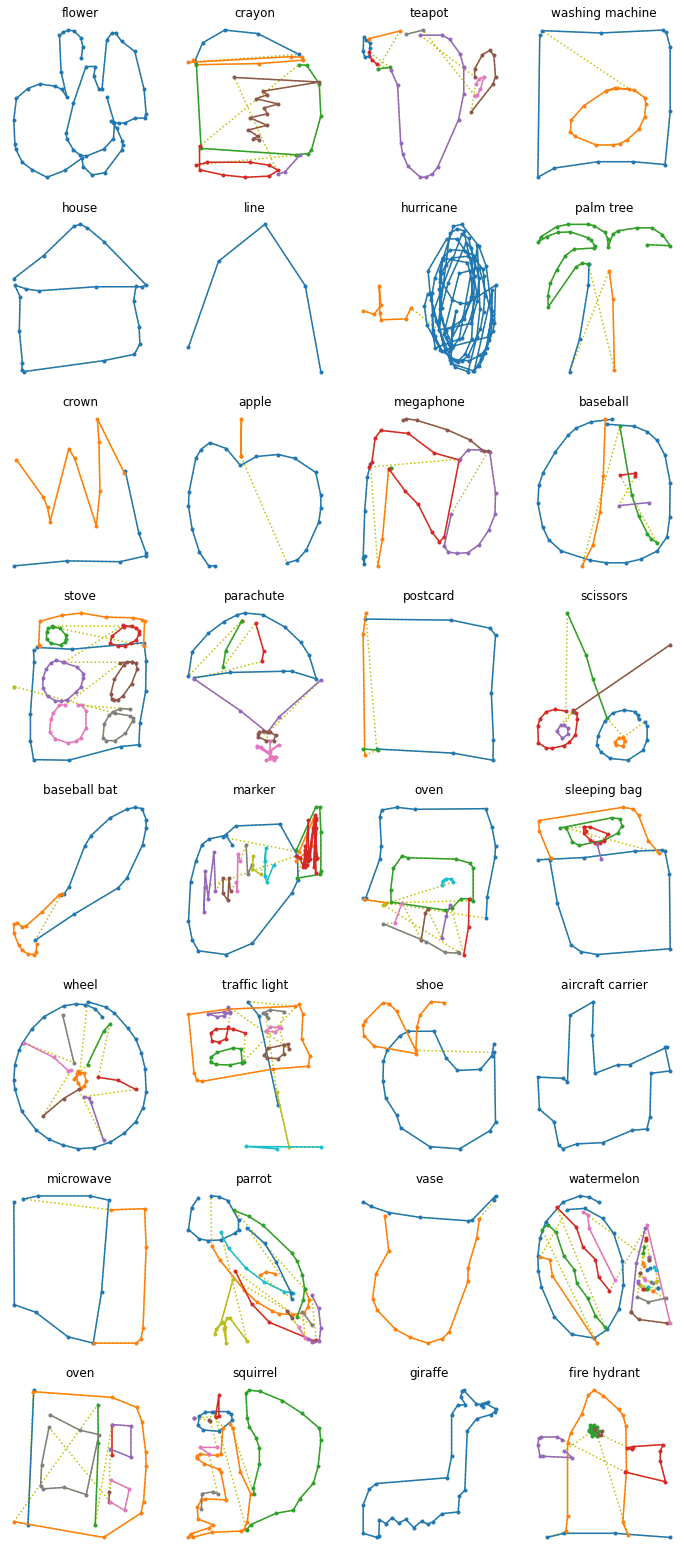

In [ ]:
# Display examples of each class
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

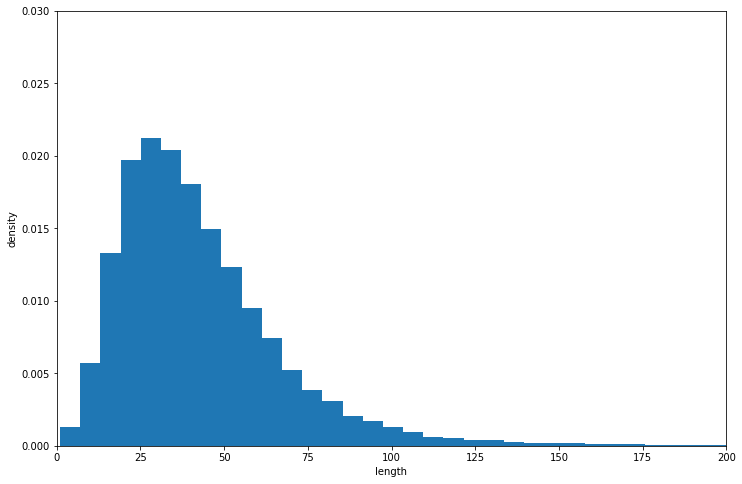

In [ ]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.figure(figsize=(12,8))
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [ ]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

We'll now construct our model. It differs a bit from the author's in that we use one less convolutional layer, but for both of the convolutional layers, we use 3 kernels rather than using 5 for all but the last convo layer. We'll also use  two strides per layer to decrease the output volume, which will allow for lower memory usage and potentially less overfitting. We're inserting batch norm layers after each convo layer to speed up the process. 

Additionally, we'll be using two GRU layers rather than two LSTM layers. GRU layers are simpler than LSTM while offering similar accuracy, so that may help speed up our model. Finally, we'll be using an Adam optimizer rather than SGD because the former often converges faster and is less likely to get stuck in a local minimum. 

Following the author's lead, we're only going to run this for two epochs because each epoch takes several minutes, even running on a GPU. If we wanted to increase our accuracy, training for additional epochs would be advised.

In [ ]:
# Build the model
model = keras.models.Sequential([
    keras.layers.Conv1D(64, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1061s 10ms/step - loss: 2.0207 - accuracy: 0.5197 - sparse_top_k_categorical_accuracy: 0.7820 - val_loss: 1.5833 - val_accuracy: 0.6081 - val_sparse_top_k_categorical_accuracy: 0.8555
Epoch 2/2
107813/107813 [==============================] - 1011s 9ms/step - loss: 1.5093 - accuracy: 0.6247 - sparse_top_k_categorical_accuracy: 0.8657 - val_loss: 1.4344 - val_accuracy: 0.6424 - val_sparse_top_k_categorical_accuracy: 0.8758


In [ ]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [ ]:
# Find the top k test accuracy
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.8702471

We achieve a test accuracy in the high 80's, quite a bit more accurate than the author's accuracy in the high 60's. Without running further analysis, it isn't quite clear what lead to the difference. It's likely the Adam optimizer paired with a lower learning rate. Keep in mind that this is top k categorical accuracy, meaning that the correct prediction just has to be in the top k ( in this case 5 -  which is the default) prediction for it to be deemed correct. 

Finally, as the author did, let's look at a few specific top k predictions our model makes. 

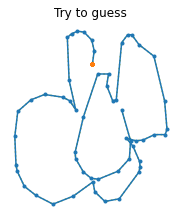

Top-5 predictions:
  1. teapot 11.974%
  2. mouse 11.651%
  3. cloud 9.400%
  4. squirrel 8.322%
  5. flower 6.718%
Answer: flower


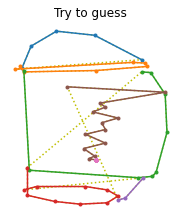

Top-5 predictions:
  1. crayon 76.075%
  2. pencil 17.975%
  3. marker 2.144%
  4. lantern 1.172%
  5. paint can 0.705%
Answer: crayon


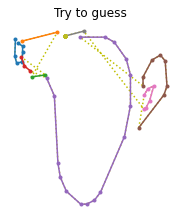

Top-5 predictions:
  1. teapot 83.859%
  2. saxophone 2.691%
  3. squirrel 1.957%
  4. bird 1.871%
  5. drill 0.768%
Answer: teapot


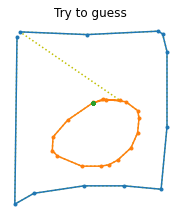

Top-5 predictions:
  1. washing machine 97.278%
  2. dishwasher 1.270%
  3. oven 0.569%
  4. camera 0.415%
  5. power outlet 0.226%
Answer: washing machine


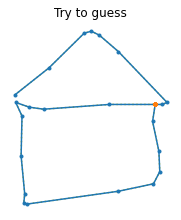

Top-5 predictions:
  1. house 97.028%
  2. barn 1.680%
  3. church 0.245%
  4. crayon 0.195%
  5. cooler 0.176%
Answer: house


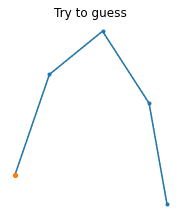

Top-5 predictions:
  1. line 29.681%
  2. garden hose 3.363%
  3. moustache 2.382%
  4. streetlight 1.677%
  5. squiggle 1.435%
Answer: line


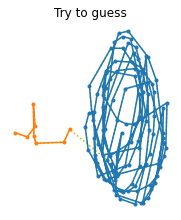

Top-5 predictions:
  1. blackberry 22.322%
  2. camouflage 17.543%
  3. hurricane 16.993%
  4. squiggle 4.232%
  5. coffee cup 2.728%
Answer: hurricane


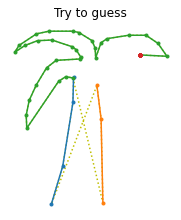

Top-5 predictions:
  1. palm tree 99.717%
  2. hammer 0.180%
  3. tree 0.031%
  4. fire hydrant 0.025%
  5. windmill 0.009%
Answer: palm tree


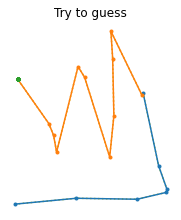

Top-5 predictions:
  1. crown 61.706%
  2. mountain 13.622%
  3. triangle 5.676%
  4. fence 1.972%
  5. yoga 1.359%
Answer: crown


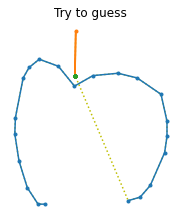

Top-5 predictions:
  1. apple 75.026%
  2. submarine 8.087%
  3. pond 4.309%
  4. mouse 3.787%
  5. pool 2.361%
Answer: apple


In [ ]:
# Display predictions for select sketches 
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))

It appears that the model does a fairly good job with the samples shown above. However, in certain cases, the top vote getter may fail to capture the majority of votes, suggesting a great deal of uncertainty.

In [ ]:
model.save("my_sketchrnn")